In [2]:
!pip install transformers sentencepiece datasets

     |████████████████████████████████| 2.6 MB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 36.5 MB/s 
     |████████████████████████████████| 264 kB 46.6 MB/s 
     |████████████████████████████████| 636 kB 48.7 MB/s 
     |████████████████████████████████| 895 kB 39.5 MB/s 
     |████████████████████████████████| 3.3 MB 35.2 MB/s 
     |████████████████████████████████| 243 kB 43.2 MB/s 
     |████████████████████████████████| 118 kB 46.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install seaborn

In [3]:
from datasets import load_dataset

from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

/usr/local/lib/python3.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
model_repo = 't5_model.pt'
model_path = '/content/sample_data/t7_translation.pt'
max_seq_len = 20

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62M [00:00<?, ?B/s]

In [6]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

Downloading:   0%|          | 0.00/312M [00:00<?, ?B/s]

In [7]:
token_ids = tokenizer.encode(
    '<zh> This will be translated to German! (hopefully)',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[    8, 11104, 39634,  9952,   208,    75,    34, 13415,     9,  8214,
            50,    22, 54386,   179, 34268,    17,     0]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


tensor([[65000,   789,   780,   384, 32615,  1035,  2038,    50,    22,  1097,
          2854,    17,     0]], device='cuda:0')
<pad> 这本会翻译成德文! (希望如此)


In [8]:
example_input_str = '<zh>This is just a test nbuig.'

input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[    8, 11104, 39634,  9952, 20565,    32,   305,    13,  5896,  7621,
         12261,  8543,     6,     0]])
Tokens: ['▁', '<', 'zh', '>', 'This', '▁is', '▁just', '▁a', '▁test', '▁n', 'bu', 'ig', '.', '</s>']


In [9]:
from datasets import load_dataset, Dataset

dataset = load_dataset("opus100", "en-zh")

Downloading:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset opus100 downloaded and prepared to /root/.cache/huggingface/datasets/opus100/en-zh/0.0.0/a87abd612d82947c7a2c3991f71095a98f55141af7ad37516dfb31bfa3511ddc. Subsequent calls will reuse this data.


In [10]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [11]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'zh': '<zh>',
}

In [12]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(65003, 512)

In [13]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

tensor([[65002,   208,    32,   305,    13,  5896,  7621, 12261,  8543,     6,
             0, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000]])
['<zh>', '▁This', '▁is', '▁just', '▁a', '▁test', '▁n', 'bu', 'ig', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [14]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]
  
def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)
  
  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)
  
  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)
    
    if formatted_data is None:
      continue
    
    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
    
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [15]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<en> ▁ 第六十一届会议 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁Sixty - first ▁session </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

In [16]:
n_epochs = 1
batch_size = 16
print_freq = 50
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [17]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

In [18]:
losses = []

In [19]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [20]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
                
  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
      
    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

torch.save(model.state_dict(), model_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/62500 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 4.045 | lr: 4e-05
Epoch: 1 | Step: 100 | Avg. loss: 2.622 | lr: 8e-05
Epoch: 1 | Step: 150 | Avg. loss: 2.418 | lr: 0.00012
Epoch: 1 | Step: 200 | Avg. loss: 2.278 | lr: 0.00016
Epoch: 1 | Step: 250 | Avg. loss: 2.448 | lr: 0.0002
Epoch: 1 | Step: 300 | Avg. loss: 2.284 | lr: 0.00024
Epoch: 1 | Step: 350 | Avg. loss: 2.272 | lr: 0.00028000000000000003
Epoch: 1 | Step: 400 | Avg. loss: 2.228 | lr: 0.00032
Epoch: 1 | Step: 450 | Avg. loss: 2.165 | lr: 0.00035999999999999997
Epoch: 1 | Step: 500 | Avg. loss: 2.168 | lr: 0.0004
Epoch: 1 | Step: 550 | Avg. loss: 2.208 | lr: 0.00044
Epoch: 1 | Step: 600 | Avg. loss: 2.149 | lr: 0.00048
Epoch: 1 | Step: 650 | Avg. loss: 4.218 | lr: 0.0004997979797979798
Epoch: 1 | Step: 700 | Avg. loss: 3.522 | lr: 0.0004993939393939394
Epoch: 1 | Step: 750 | Avg. loss: 3.438 | lr: 0.000498989898989899
Epoch: 1 | Step: 800 | Avg. loss: 3.504 | lr: 0.0004985858585858586
Epoch: 1 | Step: 850 | Avg. loss: 3.323 | lr: 0.0004981818

In [21]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

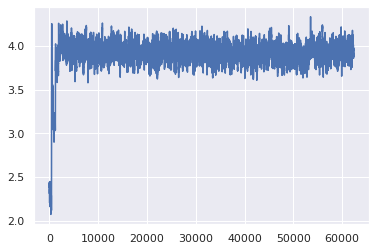

In [22]:
window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

In [24]:
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'zh',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: The Global Programme of Action Coordination Office, with the financial support of Belgium, is currently assisting Egypt, Nigeria, United Republic of Tanzania, Sri Lanka and Yemen to develop pilot national programmes of action for the protection of the marine environment from land-based activities.
Truncated input text: <zh> The▁Global▁Programme of▁Action▁Coordination▁Office, with the▁financial▁support of▁Belgium, is▁currently▁assisting▁Egypt,▁Nigeria,▁United▁Republic of▁Tanzania,▁Sri▁Lanka and▁Yemen to▁develop▁pilot▁national▁programmes of▁action for the▁protection of the▁marine▁environment from▁land-based▁activities.<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [25]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

In [27]:
output_language = 'zh' #@param ["en", "zh"]
#@title Slick Blue Translate
input_text = 'A surfboarder ran into a shark' #@param {type:"string"}

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

A surfboarder ran into a shark  ->  


In [28]:
from datasets import load_dataset, load_metric

metric = load_metric("bleu")

Downloading:   0%|          | 0.00/2.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

In [29]:
 compute_metrics=metric

In [30]:
compute_metrics

Metric(name: "bleu", features: {'predictions': Sequence(feature=Value(dtype='string', id='token'), length=-1, id='sequence'), 'references': Sequence(feature=Sequence(feature=Value(dtype='string', id='token'), length=-1, id='sequence'), length=-1, id='references')}, usage: """
Computes BLEU score of translated segments against one or more references.
Args:
    predictions: list of translations to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
    max_order: Maximum n-gram order to use when computing BLEU score.
    smooth: Whether or not to apply Lin et al. 2004 smoothing.
Returns:
    'bleu': bleu score,
    'precisions': geometric mean of n-gram precisions,
    'brevity_penalty': brevity penalty,
    'length_ratio': ratio of lengths,
    'translation_length': translation_length,
    'reference_length': reference_length
Examples

In [31]:
print(f'Bleu score = {model.compute_metrics*100:.2f}')

Bleu = 33.72
